In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/content/TrainingData.csv')

# Combine features (drone x, drone y, cycle, trial number, and found target)
features = data[[' DroneX', ' DroneY', ' Cycle', ' TrialNumber',' TargetX',' TargetY', ' FoundTarget']].values
labels = data[' Faulty'].values  # "IsFaulty" as the target label

# Normalize features and labels
scaler_features = StandardScaler()
features_normalized = scaler_features.fit_transform(features)
labels = labels.astype(np.float32)  # Ensure labels are in float32

# Convert to PyTorch tensors
X = torch.tensor(features_normalized, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.unsqueeze(1)  # Add a dimension for sequence_length (sequence_length=1)
# Reshape X_test for making predictions
X_test = X_test.unsqueeze(1)  # Add a sequence length dimension of 1


# Define the LSTM model for binary classification
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for binary classification (is faulty)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)  # Apply sigmoid activation for binary classification
        return out

# Model parameters
input_size = X_train.shape[2]  # Input size should match the number of features
hidden_size = 64
num_layers = 1

# Initialize the LSTM model
lstm_classifier = LSTMBinaryClassifier(input_size, hidden_size, num_layers)



# Training parameters
learning_rate = 0.05
num_epochs = 100

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    lstm_classifier.train()
    outputs = lstm_classifier(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))  # Reshape y_train for BCELoss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
lstm_classifier.eval()
with torch.no_grad():
    predictions = lstm_classifier(X_test)
    # Apply a threshold (e.g., 0.5) to obtain binary predictions
    binary_predictions = (predictions >= 0.5).float()
    accuracy = torch.mean((binary_predictions == y_test.view(-1, 1)).float())
    print(f'Accuracy: {accuracy.item():.4f}')


Epoch [1/100], Loss: 0.7060
Epoch [11/100], Loss: 0.3652
Epoch [21/100], Loss: 0.3353
Epoch [31/100], Loss: 0.3333
Epoch [41/100], Loss: 0.3320
Epoch [51/100], Loss: 0.3310
Epoch [61/100], Loss: 0.3302
Epoch [71/100], Loss: 0.3295
Epoch [81/100], Loss: 0.3287
Epoch [91/100], Loss: 0.3277
Accuracy: 0.8936


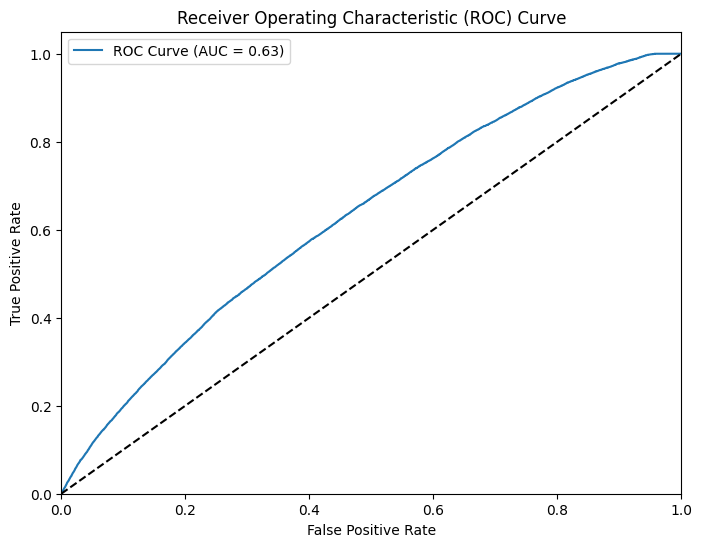

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


lstm_classifier.eval()
with torch.no_grad():
    predictions = lstm_classifier(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


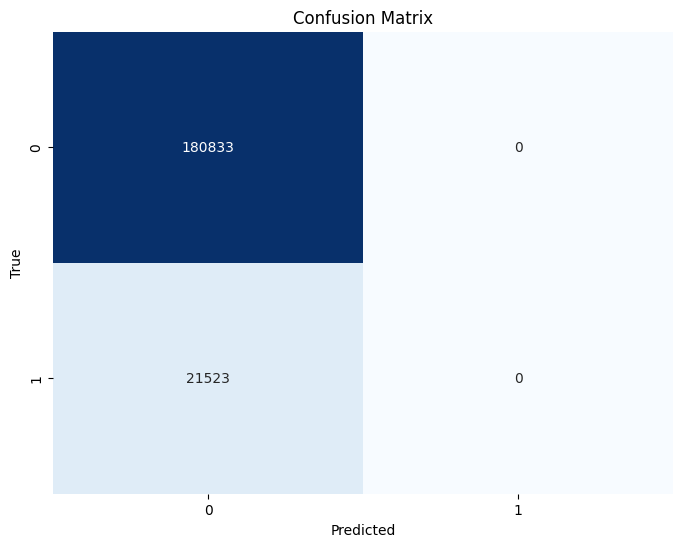

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


binary_predictions = (predictions >= 0.5).float()
cm = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the dataset
data = pd.read_csv('/content/TrainingData.csv')

# Data Preprocessing
# Convert boolean columns to integers
data[' Faulty'] = data[' Faulty'].astype(int)
data[' CanFindTarget'] = data[' CanFindTarget'].astype(int)
data[' FoundTarget'] = data[' FoundTarget'].astype(int)

# Separating features and target variable
X = data.drop([' Faulty'], axis=1).values
y = data[' Faulty'].values

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Creating data loaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_features):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# Initialize the model, loss function, and optimizer
input_features = X_train.shape[1]
model = NeuralNetwork(input_features).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output.squeeze(), target).item()
            prediction = (output.squeeze() > 0.5).float()
            correct += (prediction == target).float().sum()
    test_loss = total_loss / len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training and testing the model
num_epochs = 25
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# The output will show the progress of training and testing over epochs



Epoch: 1, Training Loss: 0.6120, Test Loss: 0.6157, Test Accuracy: 69.42%
Epoch: 2, Training Loss: 0.6165, Test Loss: 0.6166, Test Accuracy: 69.42%
Epoch: 3, Training Loss: 0.6165, Test Loss: 0.6159, Test Accuracy: 69.42%
Epoch: 4, Training Loss: 0.6165, Test Loss: 0.6161, Test Accuracy: 69.42%


KeyboardInterrupt: ignored

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Function to pad sequences
def pad_sequences(sequences, max_length):
    padded_sequences = np.zeros((len(sequences), max_length))
    for i, sequence in enumerate(sequences):
        length = len(sequence)
        padded_sequences[i, :length] = sequence
    return padded_sequences

# Load the dataset
data = pd.read_csv('TrainingData.csv')

# Group data by TrialNumber and Cycle
grouped = data.groupby([' TrialNumber', ' Cycle'])

# Prepare sequences and labels
sequences = []
labels = []

for name, group in grouped:
    # Extract relevant features for sequence
    sequence = group[[' DroneX', ' DroneY', 'DroneID', ' Cycle', ' TargetX', ' TargetY',' FoundTarget',' CanFindTarget']].values.flatten()
    # Use the 'Faulty' column as the label
    faulty_status = group[' Faulty'].iloc[0]  # Assuming all rows in a group have the same Faulty status
    sequences.append(sequence)
    labels.append(faulty_status)

# Find the maximum sequence length
max_length = max(len(seq) for seq in sequences)

# Pad sequences and convert to numpy array
sequences_padded = pad_sequences(sequences, max_length)
labels = np.array(labels)

# Normalization
scaler_sequences = StandardScaler()
sequences_normalized = scaler_sequences.fit_transform(sequences_padded)

# No need to scale labels as they are binary

# Reshape for LSTM input
sequences_normalized = sequences_normalized.reshape(-1, 1, max_length)  # 1 time step

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences_normalized, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Adjusting shape for binary output
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the LSTM model for binary classification
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for binary classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = torch.sigmoid(self.fc(out[:, -1, :]))  # Using sigmoid for binary classification
        return out

# LSTM parameters
input_size = max_length
hidden_size = 64
num_layers = 1

# Initialize the LSTM
lstm = LSTMPredictor(input_size, hidden_size, num_layers)

# Training parameters
learning_rate = 0.01
num_epochs = 100

# Loss function and optimizer for binary classification
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    lstm.train()
    outputs = lstm(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
lstm.eval()
with torch.no_grad():
    predictions = lstm(X_test)
    test_loss = criterion(predictions, y_test)

    # Thresholding predictions for binary classification
    predicted_labels = (predictions > 0.5).float()
    accuracy = (predicted_labels == y_test).float().mean()

    print(f'Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1/100], Loss: 0.7085
Epoch [11/100], Loss: 0.4518
Epoch [21/100], Loss: 0.3557
Epoch [31/100], Loss: 0.2754
Epoch [41/100], Loss: 0.2065
Epoch [51/100], Loss: 0.1678
Epoch [61/100], Loss: 0.1358
Epoch [71/100], Loss: 0.1151
Epoch [81/100], Loss: 0.1013
Epoch [91/100], Loss: 0.0926
Test Loss: 0.0981, Accuracy: 0.9691


Epoch [1/100], Train Loss: 0.7032, Test Loss: 0.6784, Accuracy: 0.6071
Epoch [11/100], Train Loss: 0.4518, Test Loss: 0.4562, Accuracy: 0.7610
Epoch [21/100], Train Loss: 0.3498, Test Loss: 0.3564, Accuracy: 0.8332
Epoch [31/100], Train Loss: 0.2692, Test Loss: 0.2776, Accuracy: 0.9279
Epoch [41/100], Train Loss: 0.2055, Test Loss: 0.2146, Accuracy: 0.9485
Epoch [51/100], Train Loss: 0.1572, Test Loss: 0.1704, Accuracy: 0.9659
Epoch [61/100], Train Loss: 0.1302, Test Loss: 0.1441, Accuracy: 0.9659
Epoch [71/100], Train Loss: 0.1126, Test Loss: 0.1264, Accuracy: 0.9693
Epoch [81/100], Train Loss: 0.0999, Test Loss: 0.1140, Accuracy: 0.9707
Epoch [91/100], Train Loss: 0.0905, Test Loss: 0.1043, Accuracy: 0.9707


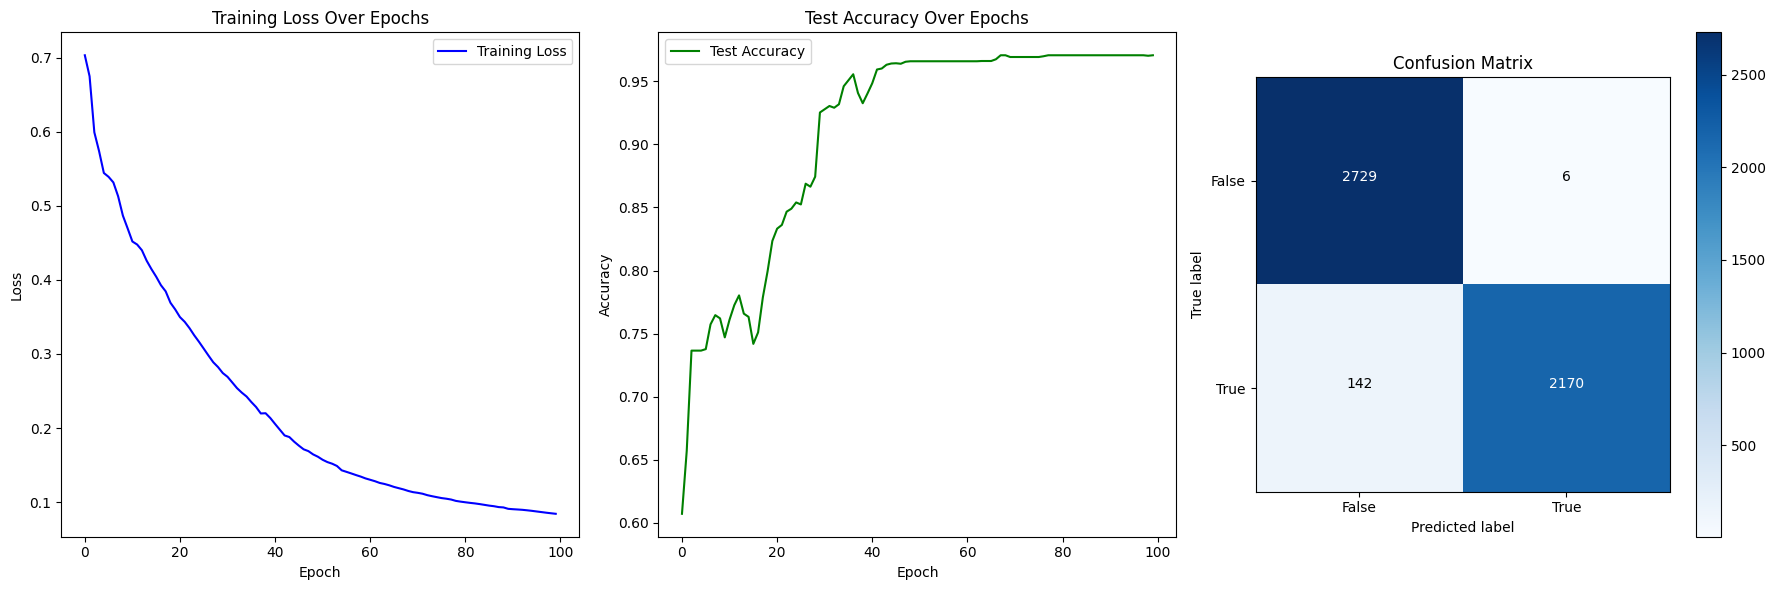

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Function to pad sequences
def pad_sequences(sequences, max_length):
    padded_sequences = np.zeros((len(sequences), max_length))
    for i, sequence in enumerate(sequences):
        length = len(sequence)
        padded_sequences[i, :length] = sequence
    return padded_sequences

# Load the dataset
data = pd.read_csv('TrainingData.csv')

# Group data by TrialNumber and Cycle
grouped = data.groupby([' TrialNumber', ' Cycle'])

# Prepare sequences and labels
sequences = []
labels = []

for name, group in grouped:
    # Extract relevant features for sequence
    sequence = group[[' DroneX', ' DroneY', 'DroneID', ' Cycle', ' TargetX', ' TargetY', ' FoundTarget', ' CanFindTarget']].values.flatten()
    # Use the 'Faulty' column as the label
    faulty_status = group[' Faulty'].iloc[0]
    sequences.append(sequence)
    labels.append(faulty_status)

# Find the maximum sequence length
max_length = max(len(seq) for seq in sequences)

# Pad sequences and convert to numpy array
sequences_padded = pad_sequences(sequences, max_length)
labels = np.array(labels)

# Normalization
scaler_sequences = StandardScaler()
sequences_normalized = scaler_sequences.fit_transform(sequences_padded)

# No need to scale labels as they are binary

# Reshape for LSTM input
sequences_normalized = sequences_normalized.reshape(-1, 1, max_length)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences_normalized, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the LSTM model for binary classification
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = torch.sigmoid(self.fc(out[:, -1, :]))
        return out

# LSTM parameters
input_size = max_length
hidden_size = 64
num_layers = 1

# Initialize the LSTM
lstm = LSTMPredictor(input_size, hidden_size, num_layers)

# Training parameters
learning_rate = 0.01
num_epochs = 100

# Loss function and optimizer for binary classification
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Initialize lists for storing metrics
train_losses = []
test_losses = []
test_accuracies = []
conf_matrices = []

# Training loop
for epoch in range(num_epochs):
    lstm.train()
    outputs = lstm(X_train)
    train_loss = criterion(outputs, y_train)
    train_losses.append(train_loss.item())

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Evaluation
    lstm.eval()
    with torch.no_grad():
        predictions = lstm(X_test)
        test_loss = criterion(predictions, y_test)
        test_losses.append(test_loss.item())

        predicted_labels = (predictions > 0.5).float()
        accuracy = (predicted_labels == y_test).float().mean()
        test_accuracies.append(accuracy.item())

        # Compute confusion matrix
        conf_mat = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
        conf_matrices.append(conf_mat)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}')

# Plotting the results
plt.figure(figsize=(18, 6))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 3, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Confusion Matrix of the last epoch
plt.subplot(1, 3, 3)
conf_mat = conf_matrices[-1]
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['False', 'True'])
plt.yticks(tick_marks, ['False', 'True'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Loop over data dimensions and create text annotations
thresh = conf_mat.max() / 2
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if conf_mat[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()

